Brain Tumor Segmentation with U-net model


Import required packages

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
#from google.colab import drive
import os
import cv2

from sklearn.model_selection import train_test_split

In [2]:
#drive.mount('/content/drive')

Load mask and brain image into array

In [3]:
#!ls 'drive/MyDrive'

In [4]:
img_width = 256
img_height = 256

In [5]:
img = []
masks = glob('dataset/kaggle_3m/*/*_mask*')
for file in masks:
  img.append(file.replace('_mask',''))  

print(masks)

['dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_14_mask.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_mask.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_3_mask.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_19_mask.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_12_mask.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_11_mask.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_2_mask.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_15_mask.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_17_mask.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_9_mask.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_16_mask.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_5_mask.tif', 'dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_13_mask.tif', 'da

Separate each dataset into training set, test set and validation set, store them into Dataframe object

In [6]:
data = pd.DataFrame(data={'brain': img, 'mask': masks})
train_dataset, test_dataset = train_test_split(data, test_size = 0.1)
train_dataset, validation_dataset = train_test_split(train_dataset,test_size = 0.2)

Data normalize function

In [7]:
def normalize_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

Training Data generator. Generate image and mask

In [8]:
def data_generator(data_frame, batch_size, aug_dict,image_color_mode="rgb",
                   mask_color_mode="grayscale", image_save_prefix="image",
                  mask_save_prefix="mask",save_to_dir=None, target_size=(256,256), seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "brain",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    for (img, mask) in train_gen:
        img, mask = normalize_data(img, mask)
        yield (img,mask)

Define loss function

In [9]:
SMOOTH = 10

def dice_coef(target, pred):
    y_targetf=K.flatten(target)
    y_predf=K.flatten(pred)
    And=K.sum(y_targetf* y_predf)
    return((2* And + SMOOTH) / (K.sum(y_targetf) + K.sum(y_predf) + SMOOTH))

def dice_coef_loss(target, pred):
    return -dice_coef(target, pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + SMOOTH) / (sum_ - intersection + SMOOTH)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)    


Unet model using keras

In [10]:
def unet(input_size=(img_width, img_height, 3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [11]:
unet_model = unet()
unet_model.summary()

2022-05-06 07:08:00.765778: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 07:08:02.883155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44182 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:86:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [12]:
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 0.001

decay = learning_rate / EPOCHS
# optimizer
optimizer = Adam(learning_rate=learning_rate, decay=decay)

Data preparation

In [13]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_data = data_generator(train_dataset, BATCH_SIZE, train_generator_args, target_size=(img_height, img_width))

val_data =  data_generator(validation_dataset, BATCH_SIZE,dict(),target_size=(img_height, img_width))

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

Train the model using dataset

In [14]:
unet_model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])
result = unet_model.fit(train_data,
                    steps_per_epoch=len(train_dataset) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_data,
                    validation_steps=len(validation_dataset) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/150


2022-05-06 07:08:14.438952: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


89/88 [==============================] - ETA: -1s - loss: -0.2253 - binary_accuracy: 0.9460 - iou: 0.1327 - dice_coef: 0.2258Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.01952, saving model to unet_brain_mri_seg.hdf5
88/88 [==============================] - 207s 2s/step - loss: -0.2253 - binary_accuracy: 0.9460 - iou: 0.1327 - dice_coef: 0.2258 - val_loss: -0.0195 - val_binary_accuracy: 0.9899 - val_iou: 0.0097 - val_dice_coef: 0.0191
Epoch 2/150
89/88 [==============================] - ETA: 0s - loss: -0.4442 - binary_accuracy: 0.9871 - iou: 0.2948 - dice_coef: 0.4440
Epoch 2: val_loss did not improve from -0.01952
88/88 [==============================] - 61s 688ms/step - loss: -0.4442 - binary_accuracy: 0.9871 - iou: 0.2948 - dice_coef: 0.4440 - val_loss: -0.0111 - val_binary_accuracy: 0.9898 - val_iou: 0.0059 - val_dice_coef: 0.0110
Epoch 3/150
89/88 [==============================] - ETA: 0s - loss: -0.5045 - b

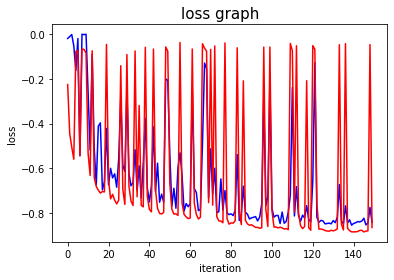

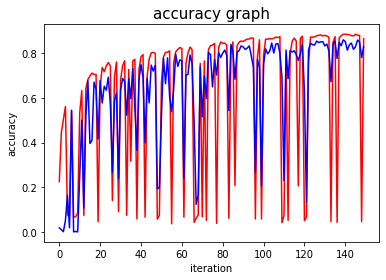

In [15]:
a = result.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [16]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [17]:
test_gen = data_generator(test_dataset, BATCH_SIZE,
                                dict(),
                                target_size=(img_height, img_width))
results = model.evaluate(test_gen, steps=len(test_dataset) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 16s 1s/step - loss: -0.8775 - binary_accuracy: 0.9976 - iou: 0.7860 - dice_coef: 0.8797
Test lost:  -0.8774858117103577
Test IOU:  0.9976485371589661
Test Dice Coefficent:  0.7859898209571838


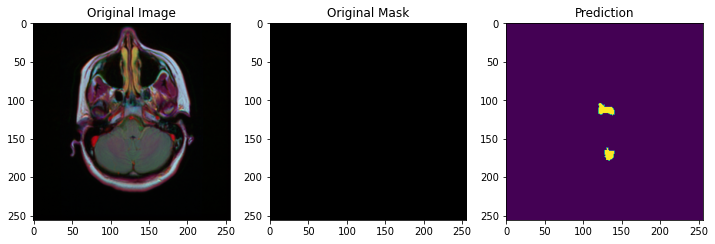

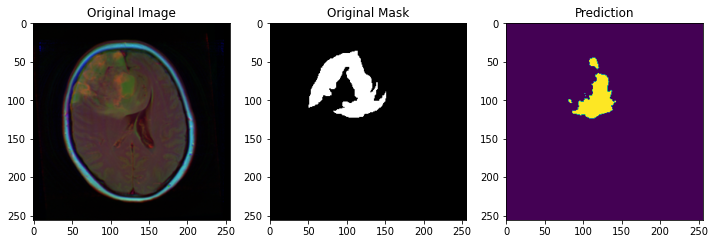

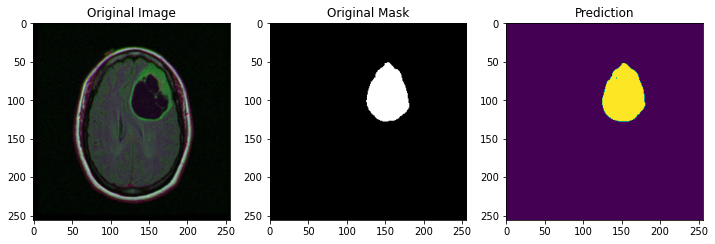

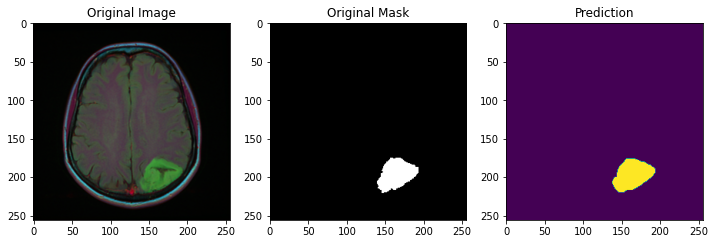

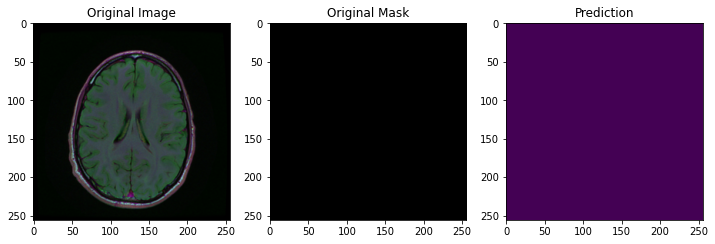

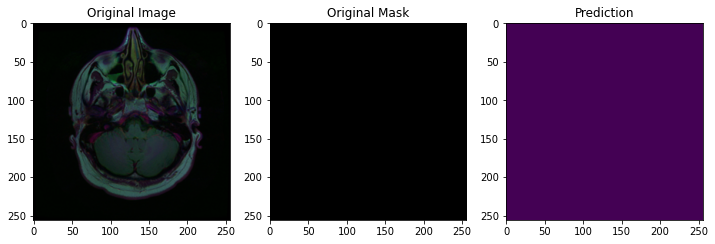

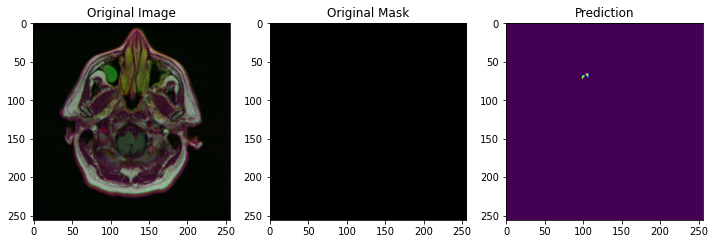

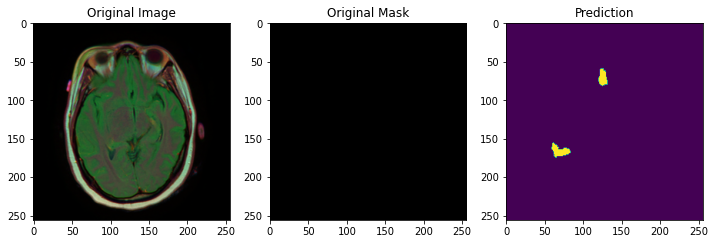

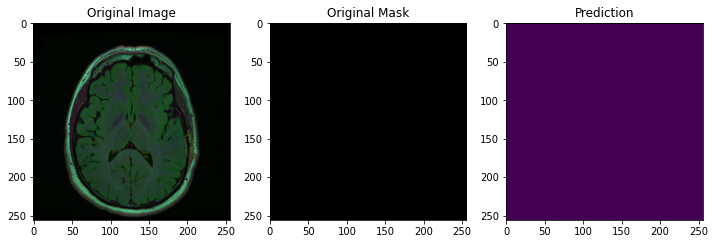

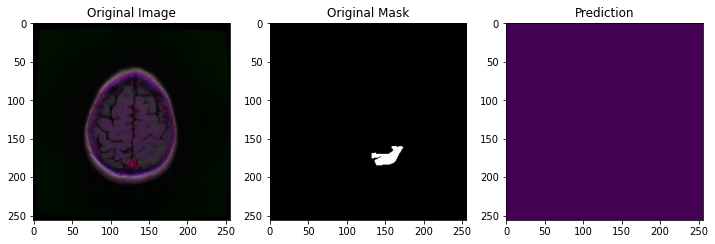

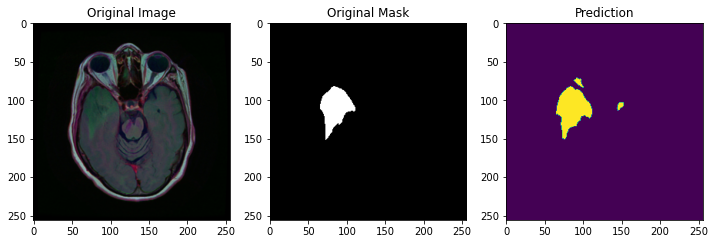

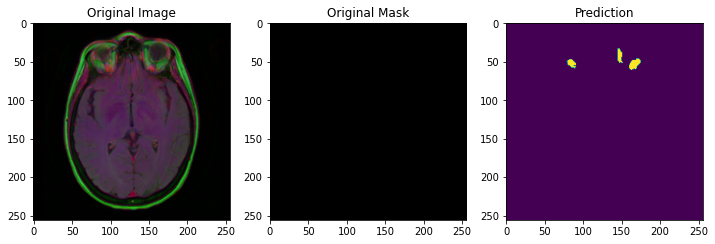

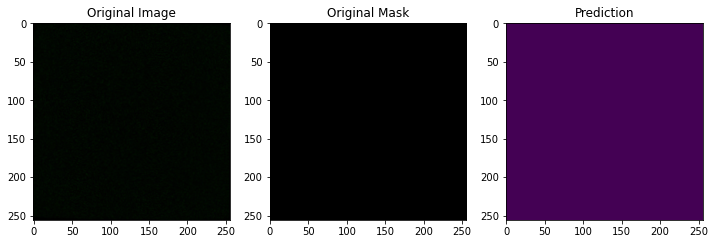

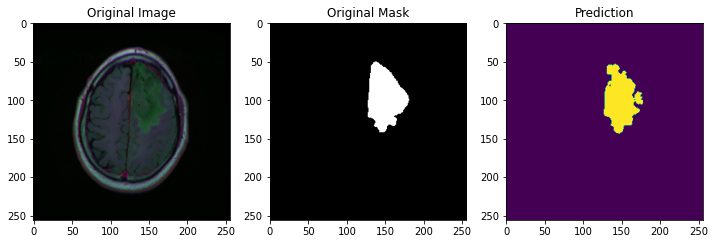

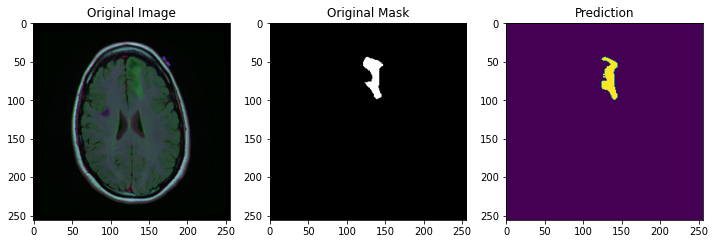

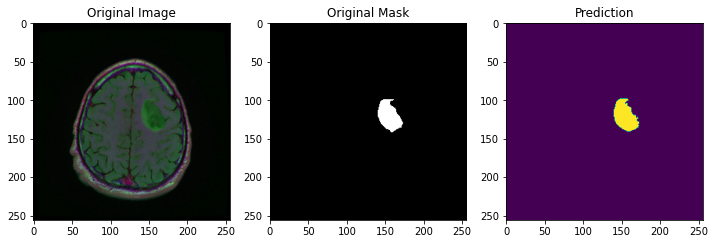

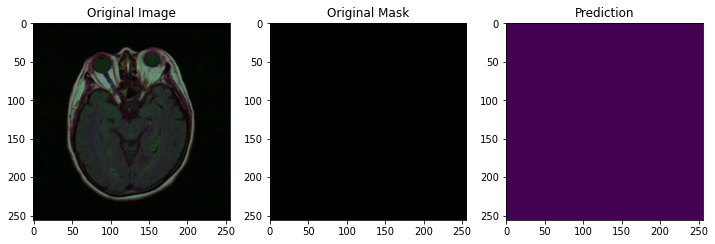

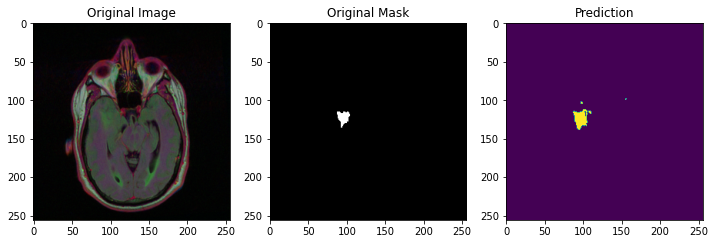

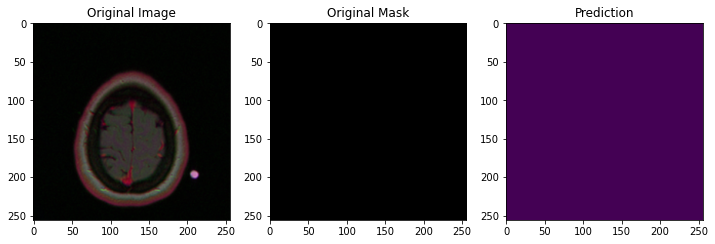

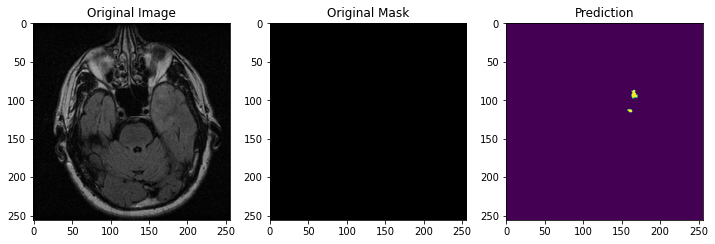

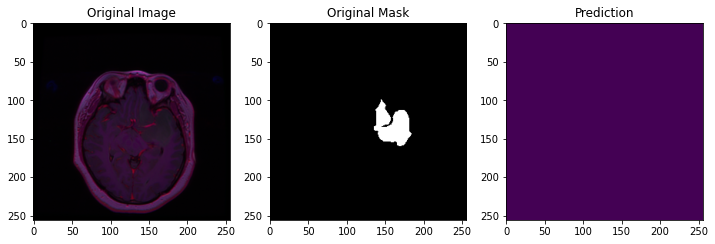

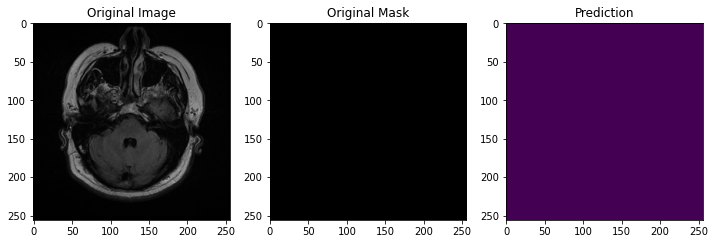

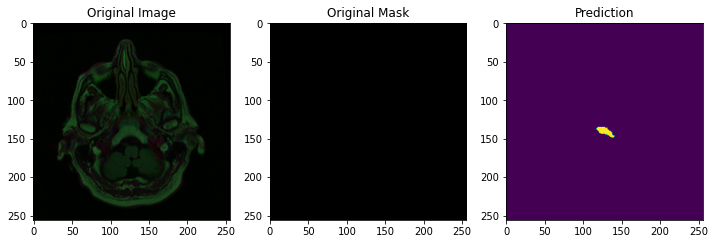

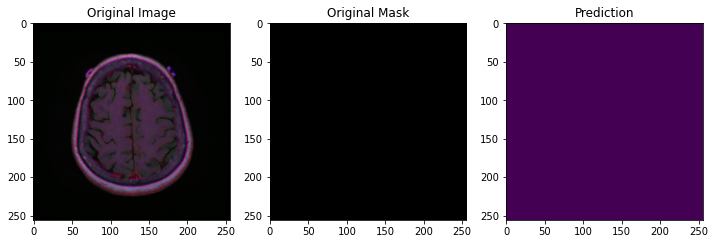

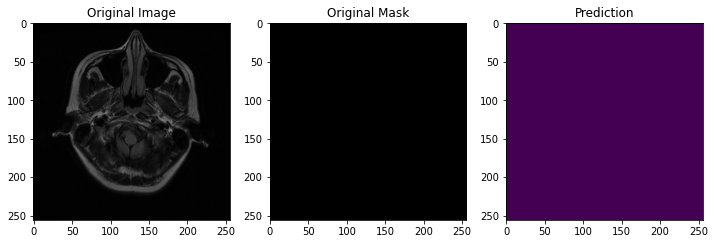

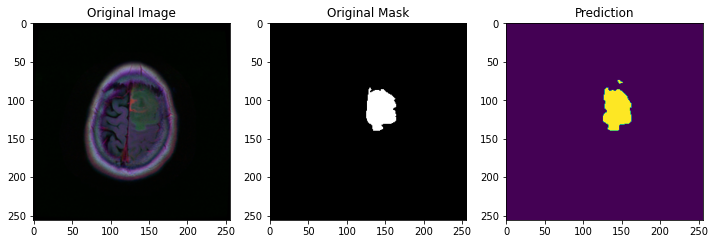

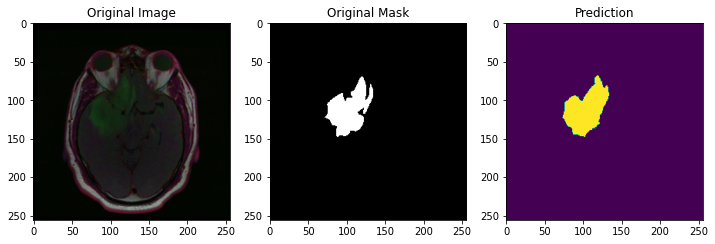

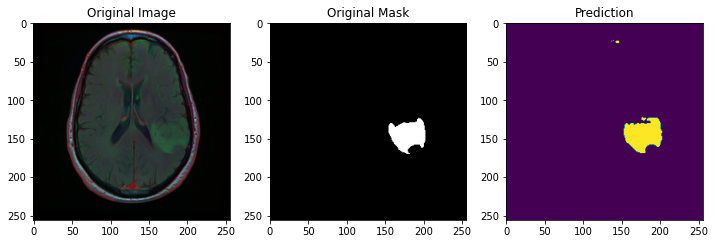

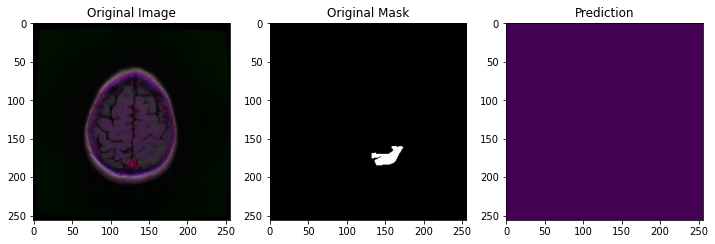

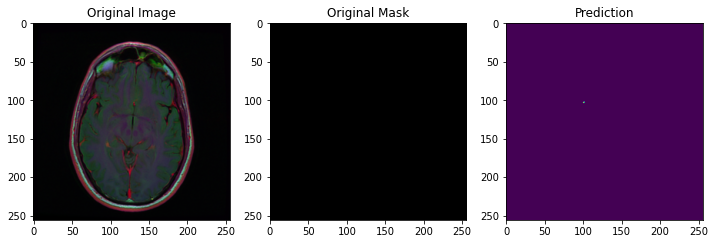

In [19]:
for i in range(30):
    index=np.random.randint(1,len(test_dataset.index))
    img = cv2.imread(test_dataset['brain'].iloc[index])
    img = cv2.resize(img ,(img_height, img_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(test_dataset['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()